# Task 3: Correlation between News Sentiment and Stock Movements

In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Set seaborn style
sns.set_style("whitegrid")

# 1. Load and parse the news dataset

In [ ]:
# Load CSV
news = pd.read_csv("../data/raw_analyst_ratings.csv")

# Strip column names
news.columns = news.columns.str.strip()

# Convert 'date' to datetime (handles timezone)
news['date'] = pd.to_datetime(news['date'], errors='coerce')

# Drop rows with invalid dates
news = news.dropna(subset=['date'])

# Extract date only (no time)
news['date_only'] = news['date'].dt.date

print("News dataset shape after cleaning:", news.shape)
print(news[['date', 'date_only']].head(10))


News dataset shape after cleaning: (55987, 7)
                       date   date_only
0 2020-06-05 10:30:54-04:00  2020-06-05
1 2020-06-03 10:45:20-04:00  2020-06-03
2 2020-05-26 04:30:07-04:00  2020-05-26
3 2020-05-22 12:45:06-04:00  2020-05-22
4 2020-05-22 11:38:59-04:00  2020-05-22
5 2020-05-22 11:23:25-04:00  2020-05-22
6 2020-05-22 09:36:20-04:00  2020-05-22
7 2020-05-22 09:07:04-04:00  2020-05-22
8 2020-05-22 08:37:59-04:00  2020-05-22
9 2020-05-22 08:06:17-04:00  2020-05-22


# 2. Align stock data dates

In [4]:
import os

def load_stock(file_path, stock_name):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    df['Stock'] = stock_name
    return df

stocks_files = ["AAPL.csv", "AMZN.csv", "GOOG.csv", "META.csv", "MSFT.csv", "NVDA.csv"]
stocks_names = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]

# Load all stocks
stocks = {name: load_stock(os.path.join("../data", file), name) 
          for file, name in zip(stocks_files, stocks_names)}


# 3. calculate daily returns for each stock

In [5]:
for name, df in stocks.items():
    df['daily_return'] = df['Close'].pct_change()

# 4. Aggregate news sentiment per day (using TextBlob)

In [6]:
from textblob import TextBlob

# Function to get sentiment score
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news['sentiment'] = news['headline'].apply(get_sentiment)

# Average sentiment per day
daily_sentiment = news.groupby('date_only')['sentiment'].mean()

# 5. Merge stock daily returns with news sentiment

In [7]:
# Example for AAPL
aapl = stocks['AAPL'].copy()
aapl['date_only'] = aapl.index.date
aapl_merged = aapl.merge(daily_sentiment, on='date_only', how='left')

# 6. Correlation between sentiment and returns

In [8]:
correlation = aapl_merged['daily_return'].corr(aapl_merged['sentiment'])
print(f"AAPL: Correlation between daily returns and news sentiment: {correlation:.4f}")

AAPL: Correlation between daily returns and news sentiment: -0.0028


In [10]:
import pandas as pd
from textblob import TextBlob

# Function to compute sentiment
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Compute sentiment for all news headlines
news['sentiment'] = news['headline'].apply(get_sentiment)
daily_sentiment = news.groupby('date_only')['sentiment'].mean()

# Dictionary to store merged data for each stock
merged_data = {}

for name, df in stocks.items():
    temp = df.copy()
    temp['daily_return'] = temp['Close'].pct_change()
    temp['date_only'] = temp.index.date
    temp_merged = temp.merge(daily_sentiment, on='date_only', how='left')
    merged_data[name] = temp_merged

# Create correlation matrix

In [12]:
# Create an empty list to collect rows
rows = []

for name, df in merged_data.items():
    corr = df['daily_return'].corr(df['sentiment'])
    rows.append({'Stock': name, 'Correlation': corr})

# Convert list of dicts to DataFrame
correlation_df = pd.DataFrame(rows)

# Display
print(correlation_df)

  Stock  Correlation
0  AAPL    -0.002815
1  AMZN    -0.019444
2  GOOG     0.014278
3  META    -0.000315
4  MSFT    -0.011811
5  NVDA     0.009129


## Visualize as a heatmap

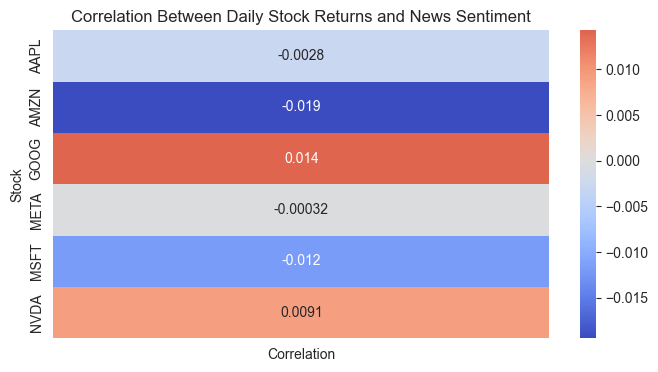

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set stock as index for heatmap
corr_matrix = correlation_df.set_index('Stock')

plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between Daily Stock Returns and News Sentiment")
plt.show()


# Rolling Correlation (14-day)

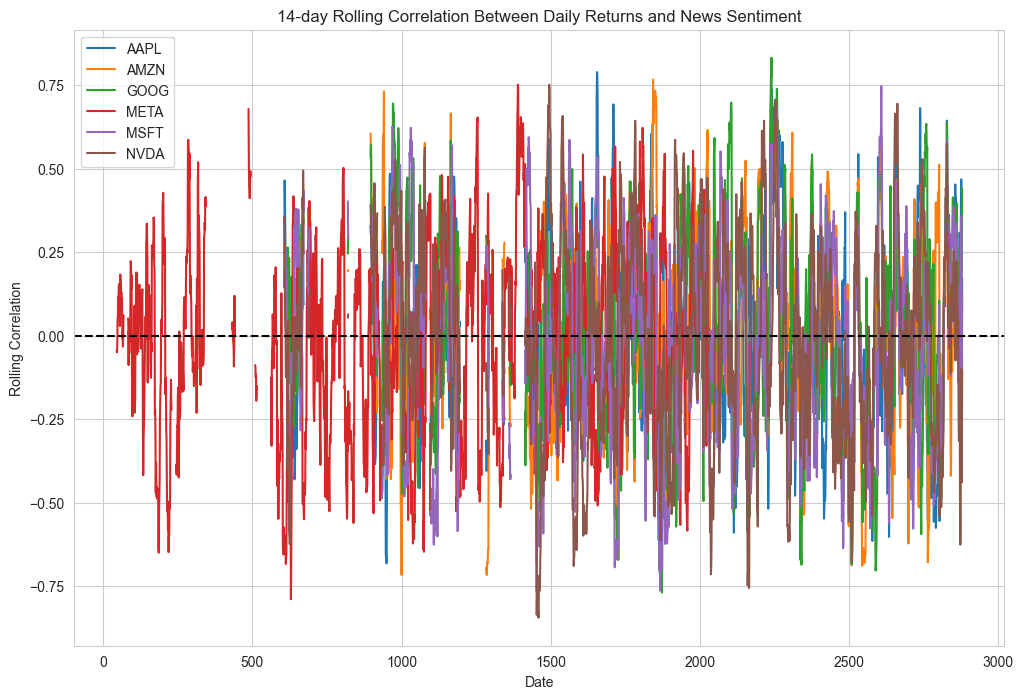

In [ ]:
# -----------------------------
plt.figure(figsize=(12,8))
for name, df in merged_data.items():
    df['rolling_corr'] = df['daily_return'].rolling(14).corr(df['sentiment'])
    plt.plot(df.index, df['rolling_corr'], label=name)
plt.axhline(0, color='black', linestyle='--')
plt.title("14-day Rolling Correlation Between Daily Returns and News Sentiment")
plt.ylabel("Rolling Correlation")
plt.xlabel("Date")
plt.legend()
plt.show()

# Trend Visualization

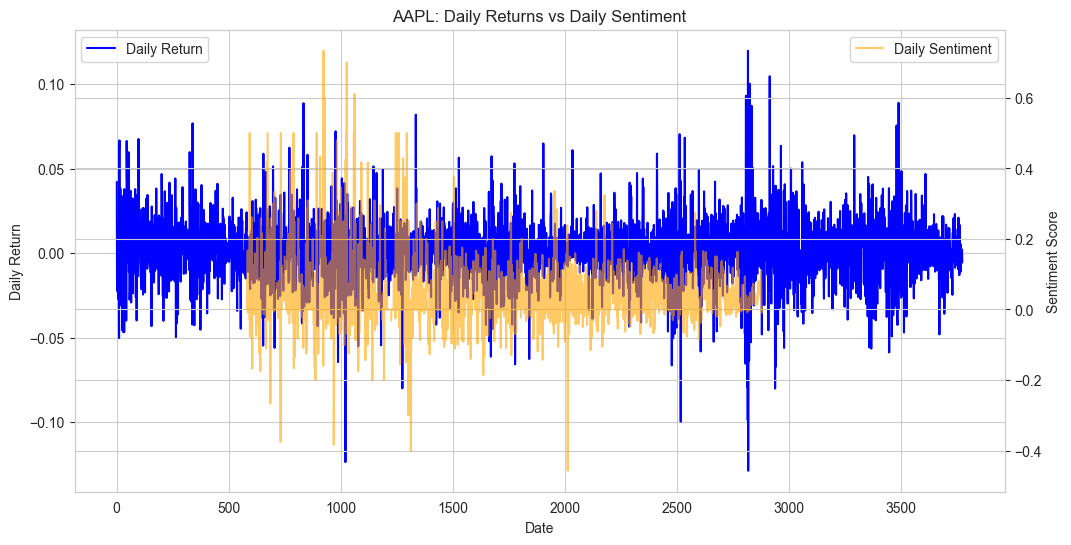

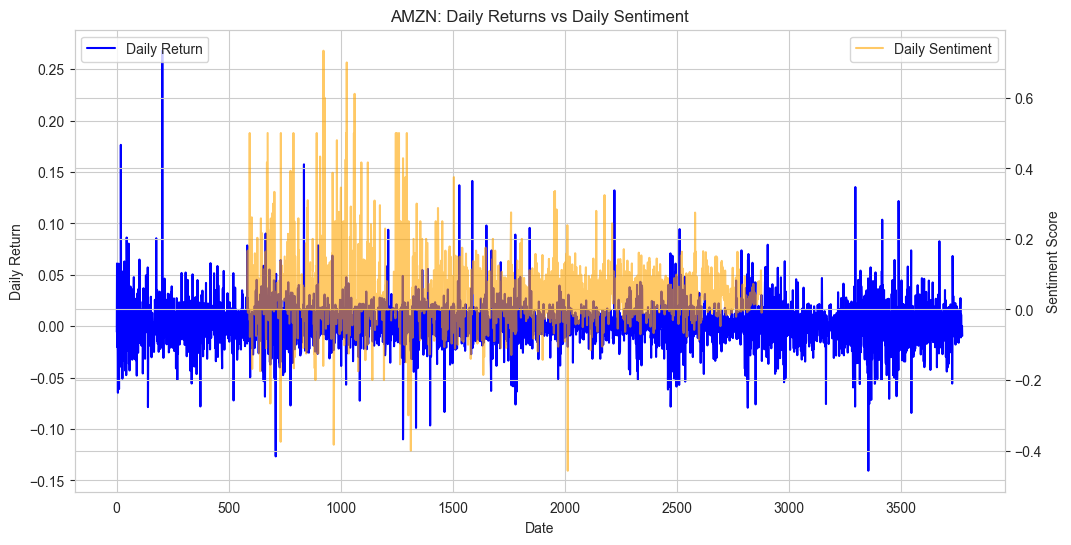

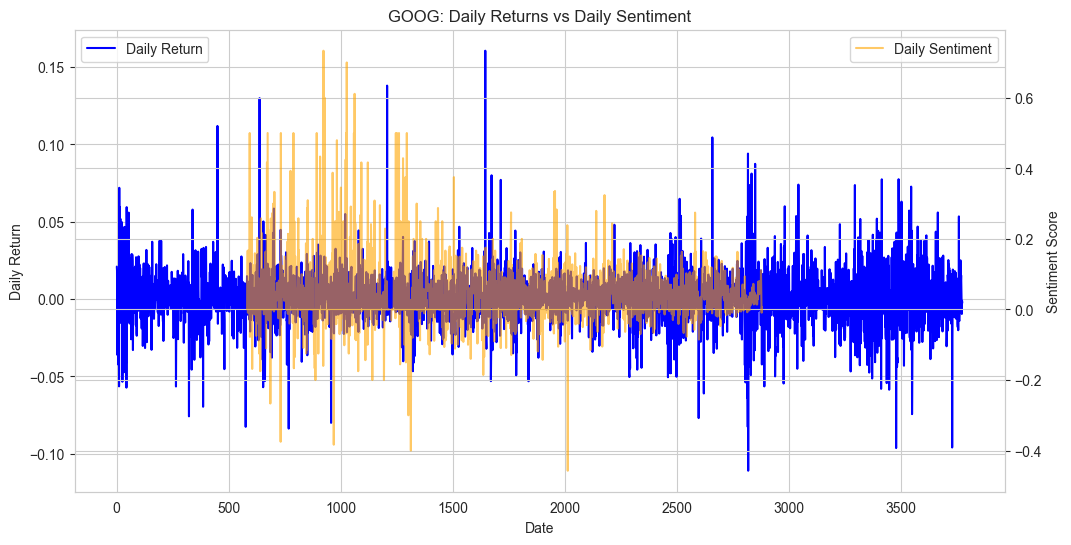

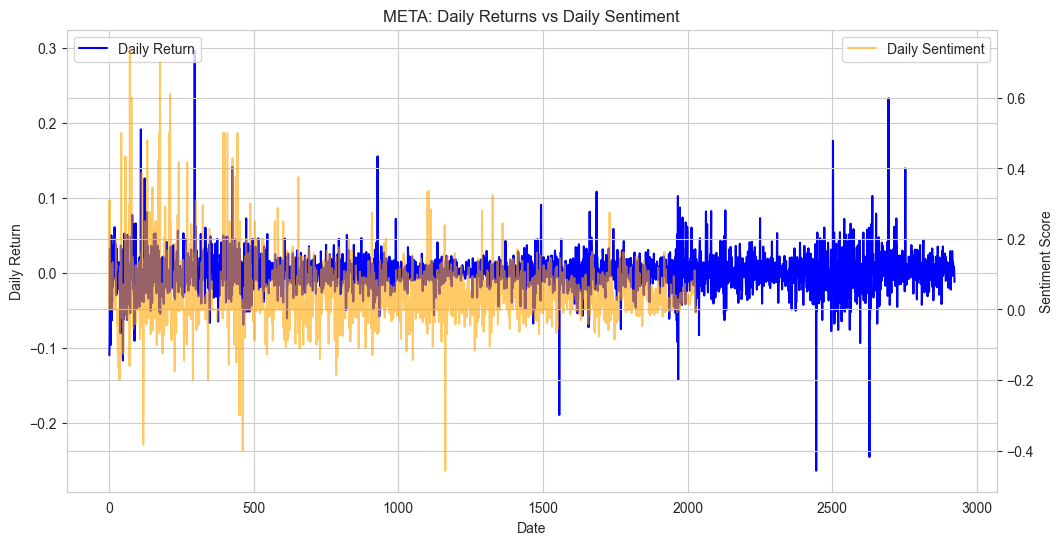

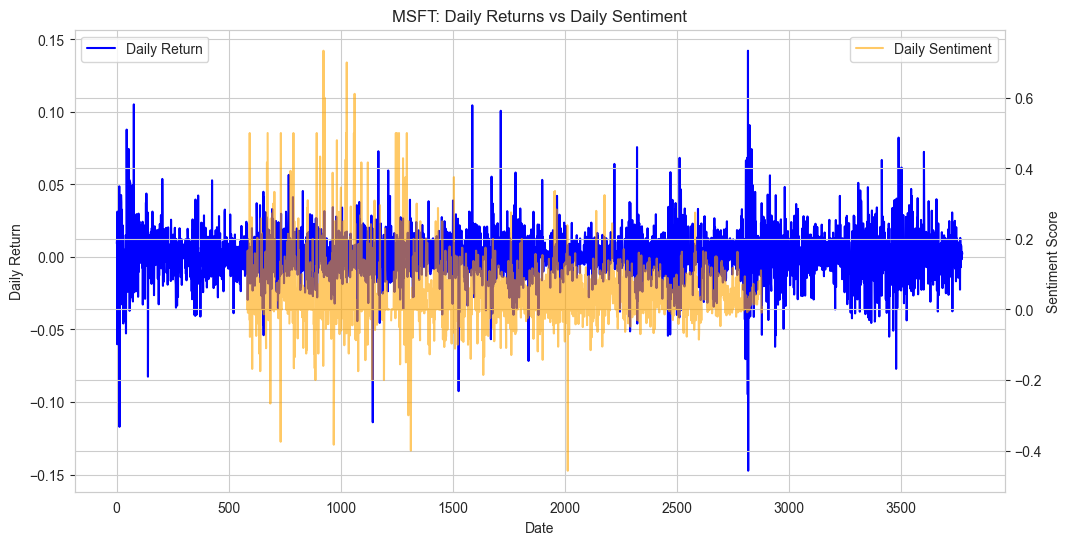

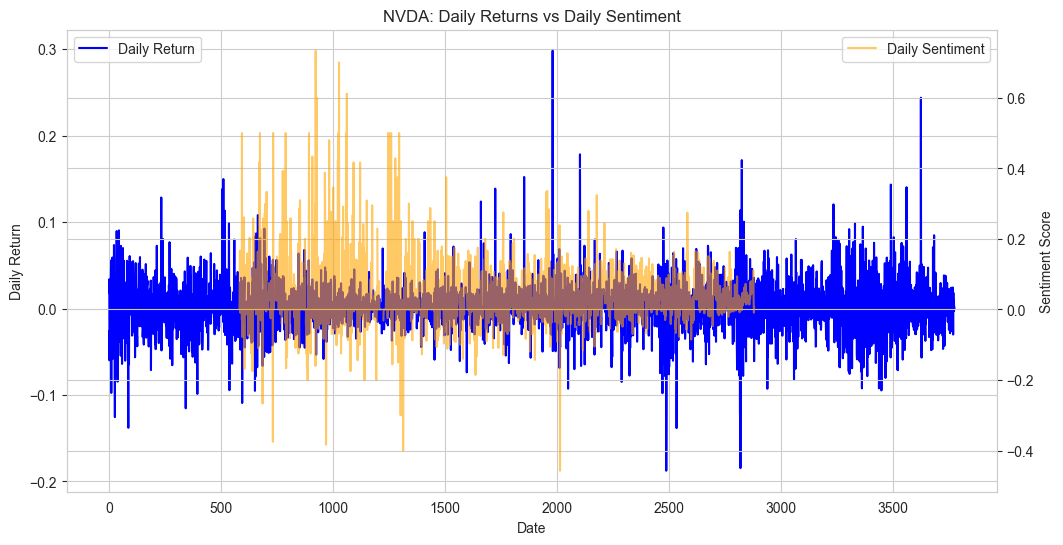

In [16]:
# -----------------------------
for name, df in merged_data.items():
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    ax1.plot(df.index, df['daily_return'], color='blue', label='Daily Return')
    ax2.plot(df.index, df['sentiment'], color='orange', label='Daily Sentiment', alpha=0.6)
    ax1.set_title(f"{name}: Daily Returns vs Daily Sentiment")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Daily Return")
    ax2.set_ylabel("Sentiment Score")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

# Distribution Plots

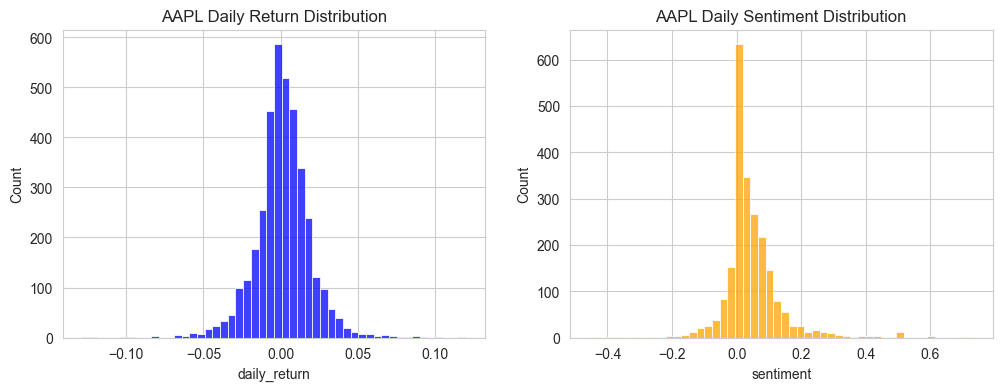

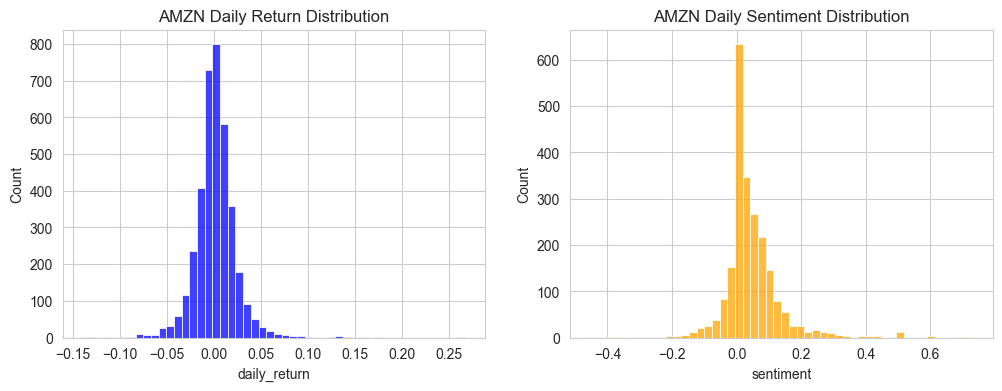

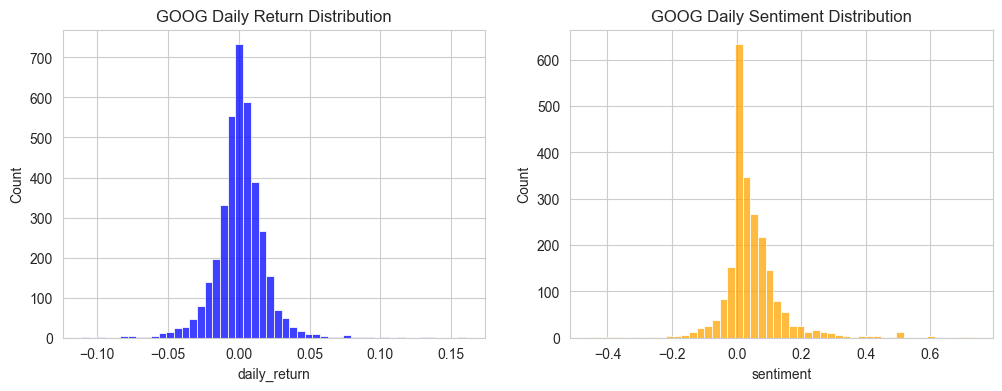

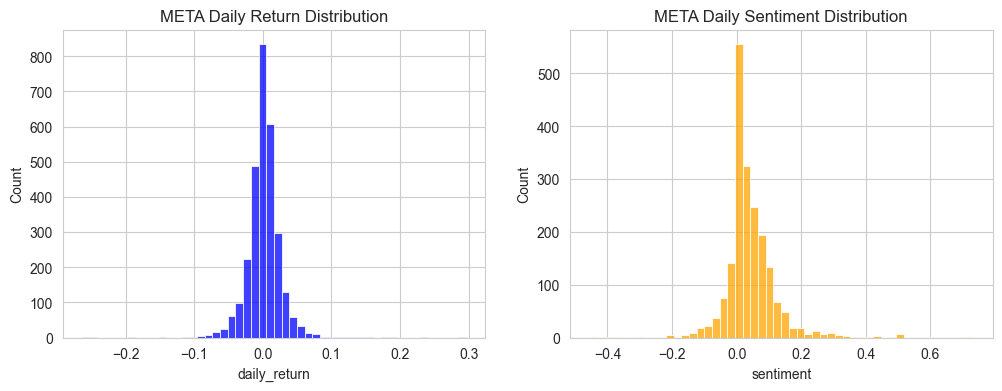

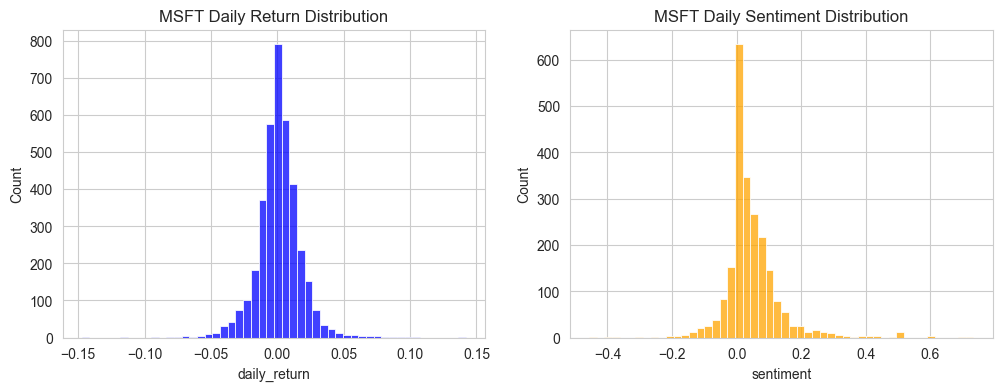

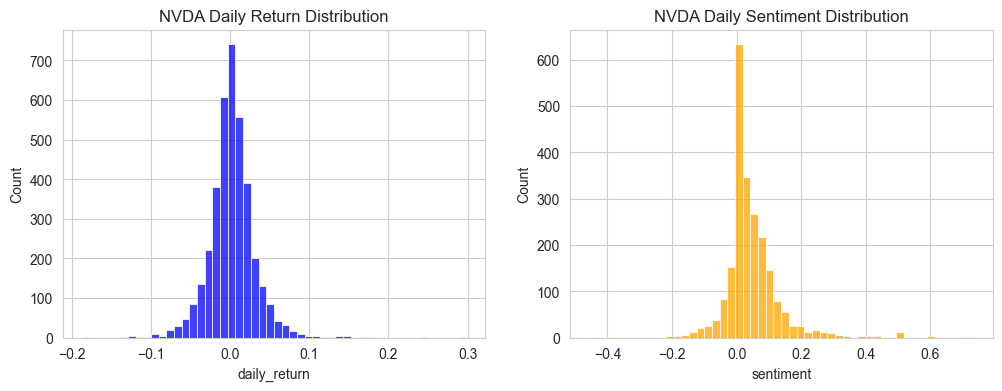

In [17]:
# -----------------------------
for name, df in merged_data.items():
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df['daily_return'].dropna(), bins=50, ax=axes[0], color='blue')
    axes[0].set_title(f"{name} Daily Return Distribution")
    sns.histplot(df['sentiment'].dropna(), bins=50, ax=axes[1], color='orange')
    axes[1].set_title(f"{name} Daily Sentiment Distribution")
    plt.show()

# scatter plot to visualize the relationship between daily returns and news sentiment for each stock

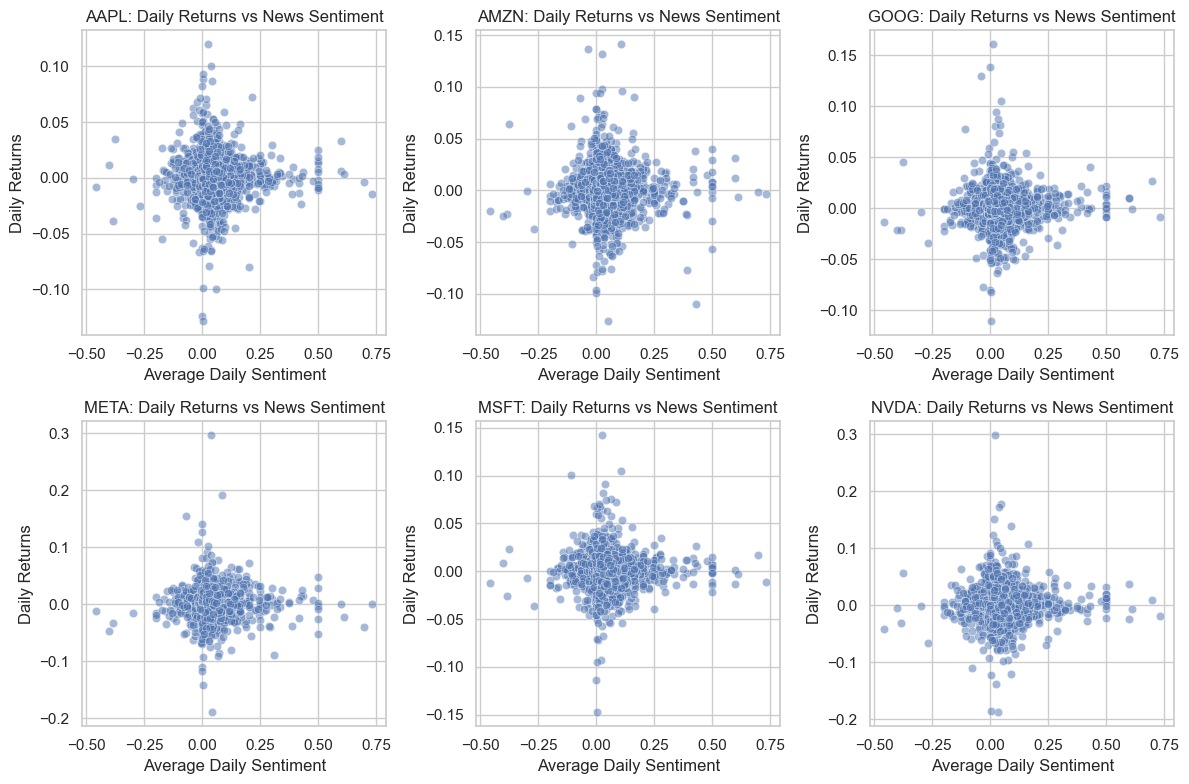

In [20]:
# Set up the plotting style
sns.set(style="whitegrid")

# Create scatter plots for all stocks
plt.figure(figsize=(12, 8))

for i, (stock, df) in enumerate(merged_data.items(), 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns for 6 stocks
    sns.scatterplot(x=df['sentiment'], y=df['daily_return'], alpha=0.5)
    plt.title(f"{stock}: Daily Returns vs News Sentiment")
    plt.xlabel("Average Daily Sentiment")
    plt.ylabel("Daily Returns")

plt.tight_layout()
plt.show()


# Cumulative Returns vs Cumulative Sentiment

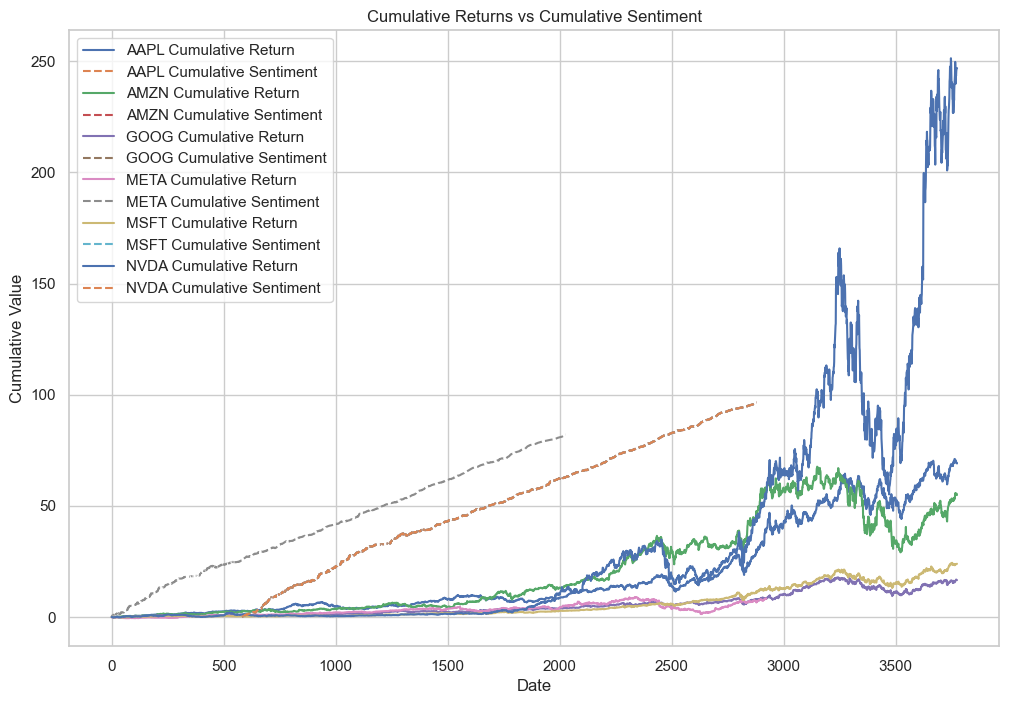

In [21]:
plt.figure(figsize=(12,8))
for stock, df in merged_data.items():
    cum_return = (1 + df['daily_return']).cumprod() - 1
    cum_sent = df['sentiment'].cumsum()
    plt.plot(df.index, cum_return, label=f"{stock} Cumulative Return")
    plt.plot(df.index, cum_sent, linestyle='--', label=f"{stock} Cumulative Sentiment")

plt.title("Cumulative Returns vs Cumulative Sentiment")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.show()


# Distribution Plots (Histograms / KDE)

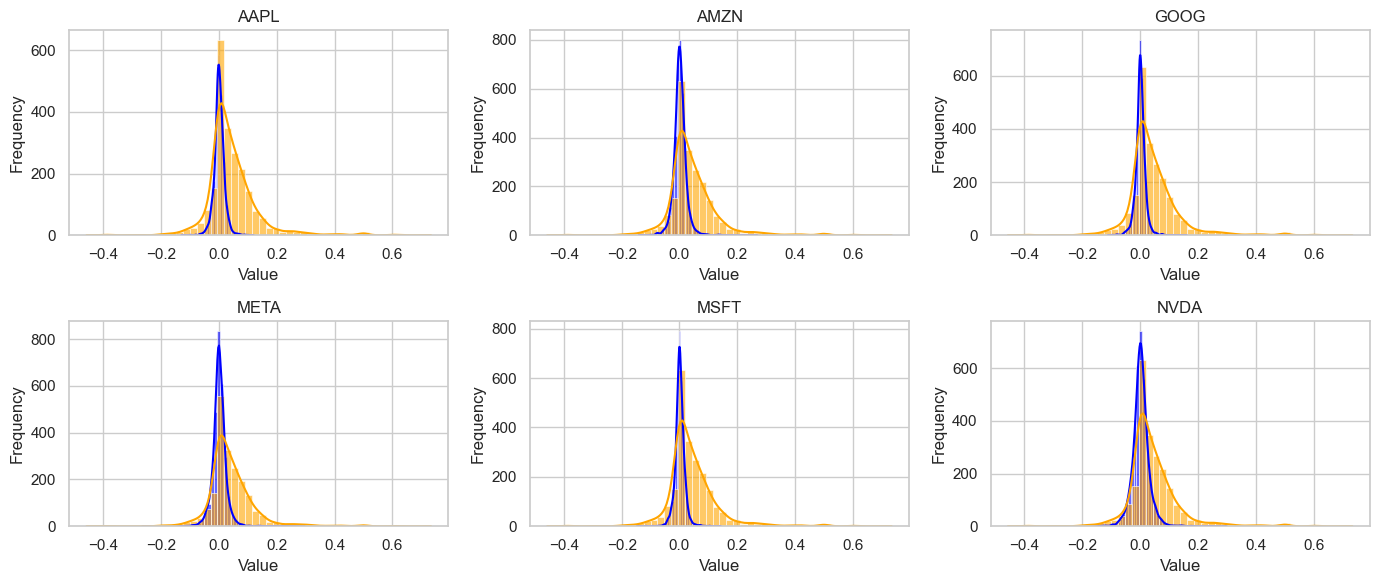

In [22]:
plt.figure(figsize=(14,6))
for i, (stock, df) in enumerate(merged_data.items(), 1):
    plt.subplot(2, 3, i)
    sns.histplot(df['daily_return'], bins=50, kde=True, color='blue', alpha=0.6)
    sns.histplot(df['sentiment'], bins=50, kde=True, color='orange', alpha=0.6)
    plt.title(stock)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Time Series Line Plot

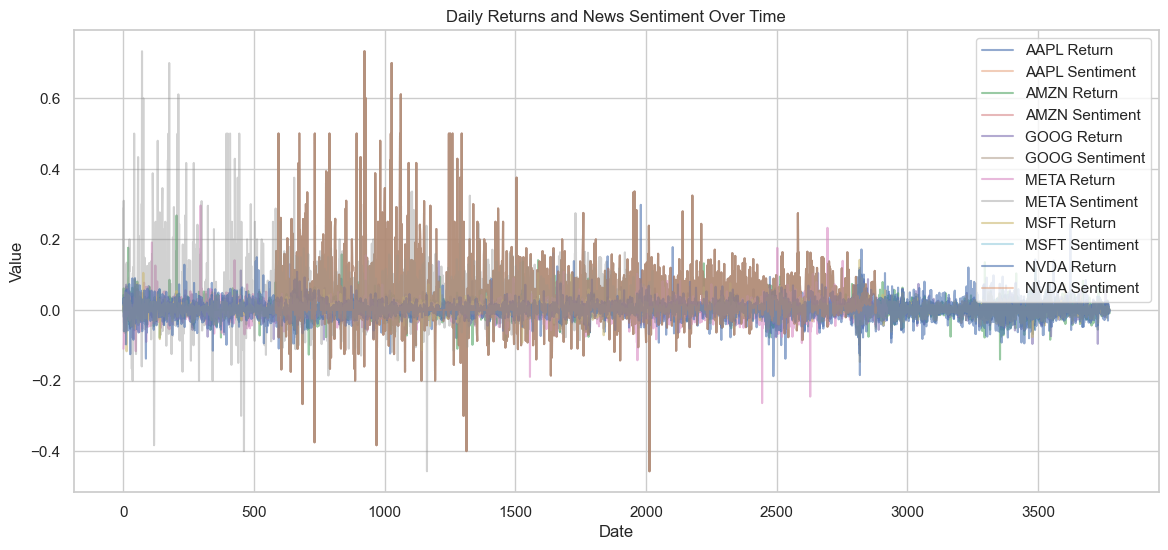

In [23]:
plt.figure(figsize=(14,6))
for stock, df in merged_data.items():
    plt.plot(df.index, df['daily_return'], label=f"{stock} Return", alpha=0.6)
    plt.plot(df.index, df['sentiment'], label=f"{stock} Sentiment", alpha=0.4)

plt.legend()
plt.title("Daily Returns and News Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

# Predictive Modeling

# STEP 1 — Compute Sentiment on Headlines
## Sentiment

In [42]:
from textblob import TextBlob

# Compute sentiment polarity
news["Sentiment"] = news["headline"].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

news[["headline", "Sentiment"]].head()

,headline,Sentiment
0,Stocks That Hit 52-Week Highs On Friday,0.0
1,Stocks That Hit 52-Week Highs On Wednesday,0.0
2,71 Biggest Movers From Friday,0.0
3,46 Stocks Moving In Friday's Mid-Day Session,0.0
4,B of A Securities Maintains Neutral on Agilent...,0.0


# STEP 2 — Aggregate Daily Sentiment per Stock

In [43]:
# Convert date_only to datetime
news["date_only"] = pd.to_datetime(news["date_only"])

daily_sentiment = (
    news.groupby(["stock", "date_only"])["Sentiment"]
    .mean()
    .reset_index()
)

daily_sentiment.head()

,stock,date_only,Sentiment
0,A,2020-05-22,0.035714
1,A,2020-05-26,0.000000
2,A,2020-06-03,0.000000
3,A,2020-06-05,0.000000
4,AA,2020-05-18,0.062500


# STEP 3 — Combine All Stock Price Data

In [44]:
all_stocks = pd.concat(stocks.values())
all_stocks = all_stocks.reset_index()

all_stocks.head()

,Date,Close,High,Low,Open,Volume,Stock,daily_return
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,AAPL,NaN
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400,AAPL,0.042204
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400,AAPL,-0.016494
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800,AAPL,-0.021609
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800,AAPL,0.018570


In [45]:
all_stocks.tail()

,Date,Close,High,Low,Open,Volume,Stock,daily_return
21788,2023-12-22,48.805527,49.358247,48.442706,49.170342,252507000,NVDA,-0.003266
21789,2023-12-26,49.254299,49.575137,48.935459,48.943454,244200000,NVDA,0.009195
21790,2023-12-27,49.392231,49.655100,49.060397,49.486186,233648000,NVDA,0.002800
21791,2023-12-28,49.497185,49.859003,49.387239,49.618126,246587000,NVDA,0.002125
21792,2023-12-29,49.497185,49.971949,48.726571,49.788039,389293000,NVDA,0.000000


# STEP 4 — Calculate Returns

In [46]:
all_stocks["Returns"] = (
    all_stocks.groupby("Stock")["Close"]
    .pct_change()
)

# STEP 5 — Add Technical Indicators

In [47]:
import talib

def add_indicators(df):
    df["RSI"] = talib.RSI(df["Close"], timeperiod=14)
    macd, macd_signal, macd_hist = talib.MACD(df["Close"])
    df["MACD"] = macd
    return df

all_stocks = all_stocks.groupby("Stock", group_keys=False).apply(add_indicators)


In [53]:
# Recreate stocks dictionary properly
stocks = {
    name: load_stock(os.path.join("../data", file), name)
    for file, name in zip(stocks_files, stocks_names)
}

# Concatenate all stocks
all_stocks = pd.concat(stocks.values())

# Reset index to bring Date back
all_stocks = all_stocks.reset_index()

print(all_stocks.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Stock'], dtype='str')


# Recreate Features

## 1. Returns

In [55]:
all_stocks["Returns"] = (
    all_stocks.groupby("Stock")["Close"]
    .pct_change()
)

## 2. Volatility

In [56]:
all_stocks["Volatility"] = (
    all_stocks.groupby("Stock")["Returns"]
    .rolling(5)
    .std()
    .reset_index(level=0, drop=True)
)

# Create Target Variable (Next Day Return)

In [57]:
# Shift returns one day forward per stock
all_stocks["Target"] = (
    all_stocks.groupby("Stock")["Returns"]
    .shift(-1)
)

# Convert to binary direction
all_stocks["Target"] = (all_stocks["Target"] > 0).astype(int)


### Now:

#### 1 → price goes UP tomorrow

#### 0 → price goes DOWN tomorrow

# Merge News Sentiment

In [65]:
from textblob import TextBlob

# Compute sentiment for each headline
news['Sentiment'] = news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Aggregate by date
sentiment_df = news.groupby('date_only')['Sentiment'].mean().reset_index()

# Rename column for merge
sentiment_df.rename(columns={'date_only': 'Date'}, inplace=True)

### Merge by Date:

In [60]:
all_stocks["Date"] = pd.to_datetime(all_stocks["Date"])
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])

all_stocks = all_stocks.merge(
    sentiment_df,
    on="Date",
    how="left"
)

### Fill missing sentiment:

In [61]:
all_stocks["Sentiment"] = all_stocks["Sentiment"].fillna(0)

# Drop NaN Values

In [62]:
all_stocks = all_stocks.dropna()

# Select Features

In [68]:
import pandas as pd
import talib

# Compute RSI per stock (safe with transform)
all_stocks['RSI'] = all_stocks.groupby('Stock')['Close'].transform(lambda x: talib.RSI(x, timeperiod=14))

# Compute MACD per stock safely
def compute_macd(group):
    macd, signal, hist = talib.MACD(group, fastperiod=12, slowperiod=26, signalperiod=9)
    # Return a Series with the same index as the group
    return pd.Series(macd, index=group.index)

# Use groupby + apply, then flatten to match the original index
all_stocks['MACD'] = all_stocks.groupby('Stock')['Close'].apply(compute_macd).reset_index(level=0, drop=True)

# Optional: Fill NaNs
all_stocks.fillna(0, inplace=True)

print(all_stocks[['Stock', 'Close', 'RSI', 'MACD']].head(10))

   Stock     Close  RSI  MACD
5   AAPL  2.716589  0.0   0.0
6   AAPL  2.659007  0.0   0.0
7   AAPL  2.630514  0.0   0.0
8   AAPL  2.559135  0.0   0.0
9   AAPL  2.500652  0.0   0.0
10  AAPL  2.469163  0.0   0.0
11  AAPL  2.345299  0.0   0.0
12  AAPL  2.484158  0.0   0.0
13  AAPL  2.650008  0.0   0.0
14  AAPL  2.650008  0.0   0.0


In [89]:
# Only classify days with >0.5% moves
all_stocks['Target'] = (all_stocks['Returns'].abs() > 0.005).astype(int)


# Create Target (Next Day Movement)

In [140]:
## 🔹 Step 0 — Setup
# Import required libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
import talib
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [141]:
## 🔹 Step 1 — Clean & Prepare News Dataset
# Load news dataset
news = pd.read_csv("../data/raw_analyst_ratings.csv")
news.columns = news.columns.str.strip()
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news = news.dropna(subset=['date'])
news['date_only'] = news['date'].dt.date

# Compute sentiment per headline
news['Sentiment'] = news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Aggregate daily sentiment per stock
daily_sentiment = news.groupby(['stock', 'date_only'])['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'date_only': 'Date'}, inplace=True)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

In [142]:
## 🔹 Step 2 — Load Stock Price Data
import os

def load_stock(file_path, stock_name):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.set_index('Date', inplace=False)
    df['Stock'] = stock_name
    return df

stocks_files = ["AAPL.csv", "AMZN.csv", "GOOG.csv", "META.csv", "MSFT.csv", "NVDA.csv"]
stocks_names = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]

# Load all stocks
stocks = {name: load_stock(os.path.join("../data", file), name)
          for file, name in zip(stocks_files, stocks_names)}

# Concatenate all stocks
all_stocks = pd.concat(stocks.values(), ignore_index=True)
all_stocks['Date'] = pd.to_datetime(all_stocks['Date'])


In [143]:
daily_sentiment = news.groupby(['stock', 'date_only'])['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'date_only': 'Date'}, inplace=True)

In [144]:
# ✅ Step 1: Compute sentiment per headline
from textblob import TextBlob

news['Sentiment'] = news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# ✅ Step 2: Aggregate daily sentiment per stock
daily_sentiment = news.groupby(['stock', 'date_only'])['Sentiment'].mean().reset_index()

# Rename columns to match all_stocks
daily_sentiment.rename(columns={'stock': 'Stock', 'date_only': 'Date'}, inplace=True)

# Convert Date columns to datetime
all_stocks['Date'] = pd.to_datetime(all_stocks['Date'])
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# ✅ Step 3: Merge daily sentiment into stock data
all_stocks = all_stocks.merge(daily_sentiment, on=['Stock', 'Date'], how='left')

# Fill missing sentiment with 0
all_stocks['Sentiment'] = all_stocks['Sentiment'].fillna(0)

# Quick check
print(all_stocks[['Stock', 'Date', 'Sentiment']].head(10))

  Stock       Date  Sentiment
0  AAPL 2009-01-02        0.0
1  AAPL 2009-01-05        0.0
2  AAPL 2009-01-06        0.0
3  AAPL 2009-01-07        0.0
4  AAPL 2009-01-08        0.0
5  AAPL 2009-01-09        0.0
6  AAPL 2009-01-12        0.0
7  AAPL 2009-01-13        0.0
8  AAPL 2009-01-14        0.0
9  AAPL 2009-01-15        0.0


In [131]:
# Drop old Sentiment column if it exists
if 'Sentiment' in all_stocks.columns:
    all_stocks = all_stocks.drop(columns=['Sentiment'])

# Merge daily_sentiment safely
all_stocks = all_stocks.merge(daily_sentiment, on=['Stock', 'Date'], how='left')

# Fill missing sentiment with 0
all_stocks['Sentiment'] = all_stocks['Sentiment'].fillna(0)


In [146]:
## 🔹 Step 3 — Feature Engineering 

import pandas as pd
import talib
from textblob import TextBlob

# 1️⃣ Compute Returns
all_stocks['Returns'] = all_stocks.groupby('Stock')['Close'].pct_change()

# 2️⃣ Rolling Volatility (5-day)
all_stocks['Volatility'] = all_stocks.groupby('Stock')['Returns'].transform(lambda x: x.rolling(5).std())

# 3️⃣ RSI & MACD
all_stocks['RSI'] = all_stocks.groupby('Stock')['Close'].transform(lambda x: talib.RSI(x, timeperiod=14))

def compute_macd(series):
    macd, signal, hist = talib.MACD(series, fastperiod=12, slowperiod=26, signalperiod=9)
    return pd.Series(macd, index=series.index)

all_stocks['MACD'] = all_stocks.groupby('Stock')['Close'].apply(compute_macd).reset_index(level=0, drop=True)

# 4️⃣ Compute Daily Sentiment
news['Sentiment'] = news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
daily_sentiment = news.groupby(['stock', 'date_only'])['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'stock': 'Stock', 'date_only': 'Date'}, inplace=True)

# Ensure datetime columns match
all_stocks['Date'] = pd.to_datetime(all_stocks['Date'])
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# 5️⃣ Merge Sentiment safely
if 'Sentiment' in all_stocks.columns:
    all_stocks = all_stocks.drop(columns=['Sentiment'])

all_stocks = all_stocks.merge(daily_sentiment, on=['Stock', 'Date'], how='left')
all_stocks['Sentiment'] = all_stocks['Sentiment'].fillna(0)

# 6️⃣ Create Lagged Features to avoid lookahead bias
lag_features = ['Returns', 'Volatility', 'RSI', 'MACD', 'Sentiment']
for f in lag_features:
    all_stocks[f + '_lag1'] = all_stocks.groupby('Stock')[f].shift(1)

# 7️⃣ Create Target: Next-Day Price Movement
all_stocks['Target'] = all_stocks.groupby('Stock')['Returns'].shift(-1)
all_stocks['Target'] = (all_stocks['Target'] > 0).astype(int)

# 8️⃣ Drop rows with NaNs caused by rolling, lag, or shift
all_stocks.dropna(inplace=True)

print("Feature Engineering Complete. Sample Data:")
print(all_stocks[['Stock', 'Date', 'Returns', 'Volatility', 'RSI', 'MACD', 'Sentiment', 'Target']].head(10))


Feature Engineering Complete. Sample Data:
      Stock       Date   Returns  Volatility        RSI      MACD  Sentiment  \
2877   AAPL 2020-06-09  0.031578    0.017010  77.181064  2.599385   0.088333   
2878   AAPL 2020-06-10  0.025728    0.017311  80.377486  2.929144   0.166919   
6651   AMZN 2020-06-09  0.030427    0.014257  71.462829  2.838777  -0.020833   
6652   AMZN 2020-06-10  0.017913    0.013804  74.324860  3.286774   0.204798   
10422  GOOG 2020-06-04 -0.016848    0.009884  58.926044  1.672910   0.000000   
10423  GOOG 2020-06-05  0.018560    0.012781  63.793238  1.648525  -0.051852   
10424  GOOG 2020-06-08  0.005715    0.012933  65.186568  1.643196   0.139394   
10425  GOOG 2020-06-09  0.006602    0.013033  66.785746  1.658128   0.066667   
10426  GOOG 2020-06-10  0.006655    0.012877  68.373275  1.689318   0.011111   
20891  NVDA 2020-06-02  0.002157    0.025651  63.176599  0.421617   0.250000   

       Target  
2877        1  
2878        0  
6651        1  
6652        

## 🔹 Step 4 — Define Model Features

In [148]:
features_lagged = [f + '_lag1' for f in lag_features]
X = all_stocks[features_lagged]
y = all_stocks['Target']

## 🔹 Step 5 — Time-Series Cross Validation (Random Forest)

In [149]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

rf_model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)
rf_accuracies = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    rf_model.fit(X_train, y_train)
    preds = rf_model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    rf_accuracies.append(acc)
    print("Fold Accuracy:", acc)

print("\nAverage Accuracy:", np.mean(rf_accuracies))
print("\nClassification Report (Last Fold):\n", classification_report(y_test, preds))

Fold Accuracy: 0.5
Fold Accuracy: 1.0
Fold Accuracy: 0.5
Fold Accuracy: 0.5
Fold Accuracy: 1.0

Average Accuracy: 0.7

Classification Report (Last Fold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2




## 🔹 Step 6 — Feature Importance

In [150]:
importance = pd.Series(rf_model.feature_importances_, index=features_lagged).sort_values(ascending=False)
print("\nFeature Importance:\n", importance)


Feature Importance:
 Volatility_lag1    0.367567
RSI_lag1           0.219389
MACD_lag1          0.161916
Returns_lag1       0.161006
Sentiment_lag1     0.090121
dtype: float64


## 🔹 Step 7 — Hyperparameter Tuning (Random Forest)

In [151]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [4, 6, 8],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4]
}

grid = GridSearchCV(rf_model, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)

print("\nBest Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Best Parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 0.7


## 🔹 Step 8 — Gradient Boosting & XGBoost

In [152]:
# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
gb_scores = cross_val_score(gb, X, y, cv=tscv, scoring='accuracy')
print("\nGradient Boosting Accuracy:", gb_scores.mean())

# XGBoost
xgb = XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, use_label_encoder=False, eval_metric='logloss'
)
xgb_scores = cross_val_score(xgb, X, y, cv=tscv, scoring='accuracy')
print("XGBoost Accuracy:", xgb_scores.mean())


Gradient Boosting Accuracy: 0.7


c:\Users\Dell\Pictures\Predicting-Price-Moves-with-News-Sentiment\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:18:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Dell\Pictures\Predicting-Price-Moves-with-News-Sentiment\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:18:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Dell\Pictures\Predicting-Price-Moves-with-News-Sentiment\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:18:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Dell\Pictures\Predicting-Price-Moves-with-News-Sentiment\venv\Lib\site-packages\xg

XGBoost Accuracy: 0.7


## 🔹 Step 9 — Evaluate Economic Performance (Sharpe Ratio)

In [153]:

final_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X, y)

# Predict signals
all_stocks['Prediction'] = final_model.predict(X)

# Strategy return = daily return * prediction signal
all_stocks['Strategy_Return'] = all_stocks['Returns'] * all_stocks['Prediction']

# Annualized Sharpe Ratio
sharpe = (all_stocks['Strategy_Return'].mean() / all_stocks['Strategy_Return'].std()) * np.sqrt(252)
print("\nStrategy Sharpe Ratio:", sharpe)



Strategy Sharpe Ratio: 5.222535018703127


c:\Users\Dell\Pictures\Predicting-Price-Moves-with-News-Sentiment\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:18:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 🔹 Step 1 — Hyperparameter Tuning for XGBoost

In [154]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=tscv,       # time-series split
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\Dell\Pictures\Predicting-Price-Moves-with-News-Sentiment\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:24:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.7}
Best CV Accuracy: 0.7


In [157]:
## 🔹 Step 2 — Train Best XGBoost Model
best_xgb = grid.best_estimator_
best_xgb.fit(X, y)


c:\Users\Dell\Pictures\Predicting-Price-Moves-with-News-Sentiment\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:32:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.7
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

## 🔹 Step 3 — Explainability with SHAP

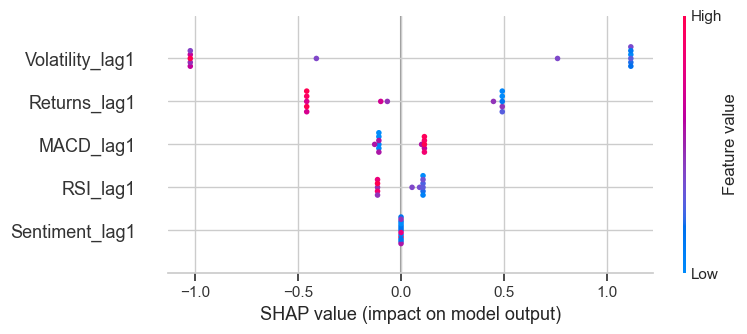

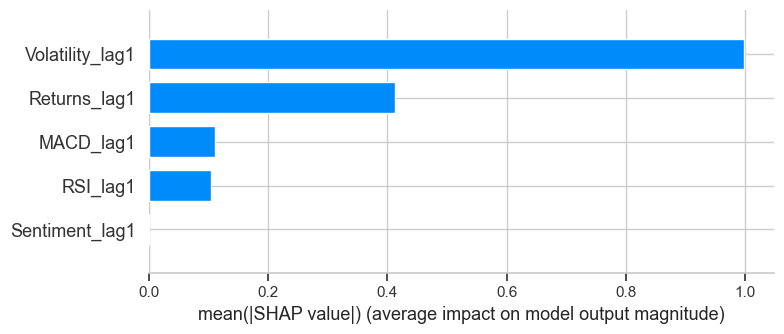

In [ ]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, feature_names=X.columns)

# Optional: Feature importance bar plot
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar")


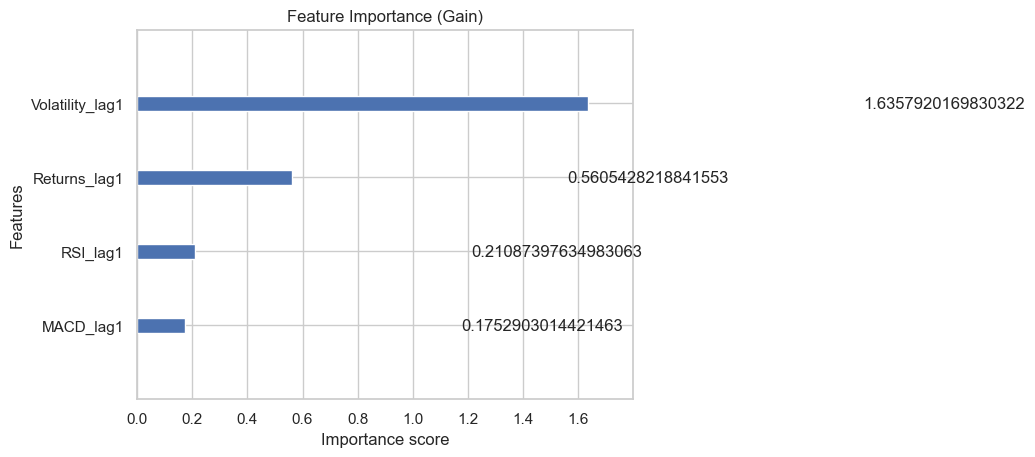

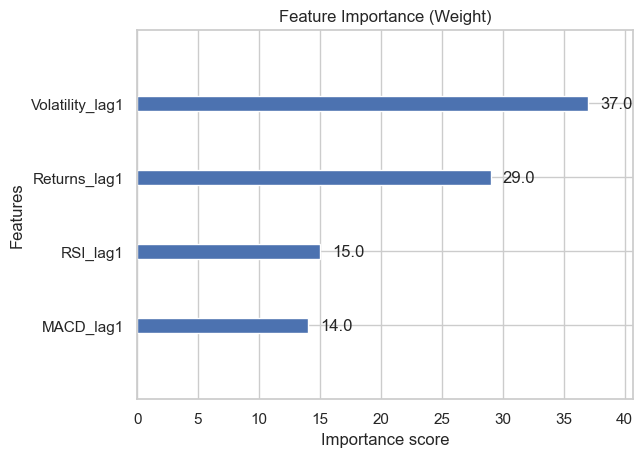

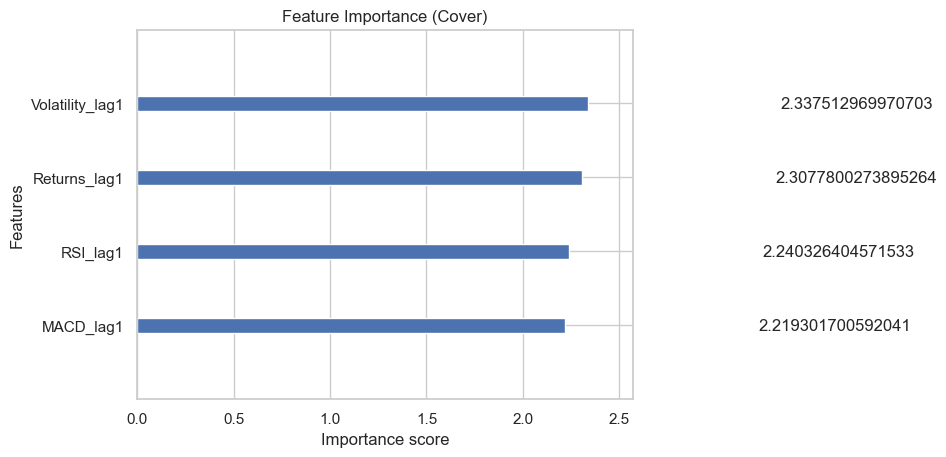

In [159]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Feature importance based on gain (average contribution to splits)
plot_importance(best_xgb, importance_type='gain', max_num_features=10, title='Feature Importance (Gain)')
plt.show()

# based on weight (number of splits)
plot_importance(best_xgb, importance_type='weight', max_num_features=10, title='Feature Importance (Weight)')
plt.show()

# based on cover (relative number of observations)
plot_importance(best_xgb, importance_type='cover', max_num_features=10, title='Feature Importance (Cover)')
plt.show()

# LIME (Local Interpretable Model-agnostic Explanations)

In [165]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Convert X to numpy array
X_array = X.values

explainer = LimeTabularExplainer(
    training_data=X_array,
    feature_names=X.columns.tolist(),
    class_names=['Down', 'Up'],
    mode='classification'
)

exp_list = exp.as_list()
print("LIME Explanation for first instance:")
for feature, weight in exp_list:
    print(f"{feature}: {weight:.4f}")

LIME Explanation for first instance:
0.01 < Volatility_lag1 <= 0.01: -0.2421
-0.00 < Returns_lag1 <= 0.01: 0.0895
RSI_lag1 > 66.79: -0.0436
1.66 < MACD_lag1 <= 2.36: 0.0287
Sentiment_lag1 <= 0.00: -0.0089


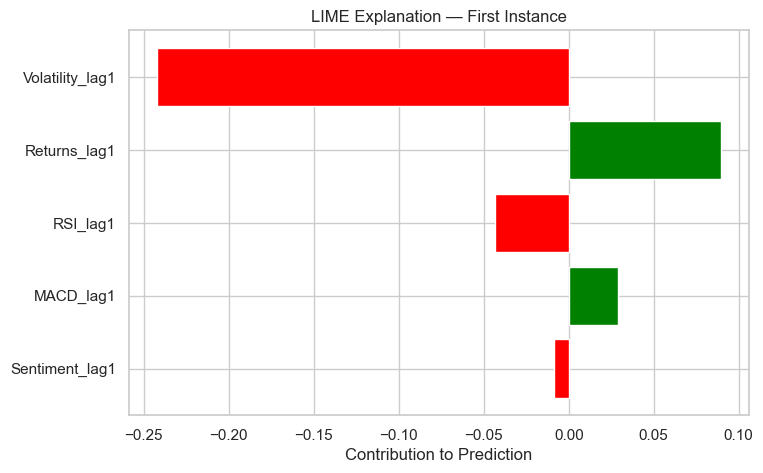

In [166]:
import matplotlib.pyplot as plt

# LIME explanation (feature, weight)
lime_explanation = [
    ("Volatility_lag1", -0.2421),
    ("Returns_lag1", 0.0895),
    ("RSI_lag1", -0.0436),
    ("MACD_lag1", 0.0287),
    ("Sentiment_lag1", -0.0089)
]

# Split features and weights
features, weights = zip(*lime_explanation)

# Plot
plt.figure(figsize=(8, 5))
colors = ['red' if w < 0 else 'green' for w in weights]  # red = negative, green = positive
plt.barh(features, weights, color=colors)
plt.xlabel("Contribution to Prediction")
plt.title("LIME Explanation — First Instance")
plt.gca().invert_yaxis()  # highest contribution on top
plt.show()


# Tree SHAP Interaction Values

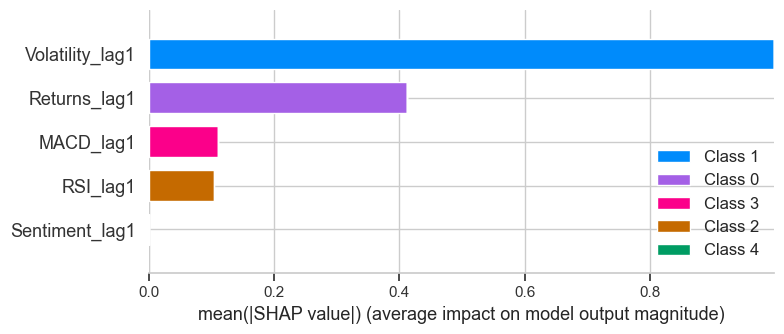

In [167]:
import shap

# Create SHAP TreeExplainer for XGBoost
explainer = shap.TreeExplainer(best_xgb)  # or final_model

# Compute SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X)

# Visualize top interactions (top 10 features)
shap.summary_plot(
    shap_interaction_values, 
    X, 
    feature_names=X.columns, 
    max_display=10,     # only top 10 features/interactions
    plot_type='bar'     # horizontal bar plot
)
